<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Webscrapping: Modeling Notebook

_Authors: Patrick Wales-Dinan_

---

This lab was incredibly challenging. We had to extensively clean a date set that was missing a lot of values and had TONS of categorical data. Then we had to decide what features to use to model that data. After that we had to build and fit the models making decisions like whether to use polynomial features, dummy variables etc, log scaling features or log scaling the depended variable.

After that we had to re run our model over and over again, looking at the different values of $\beta$ and seeing if they were contributing to the predictive power of the model. We had to decide if we should throw those values out or if we should leave them. We also had to make judgement calls to see if our model appeared to be over fitting or suffering from bias. 

## Contents:
- [Data Import](#Data-Import)
- [Baseline Accuracy](#Calculate-the-Baseline-Accuracy)
- [Data Modeling](#Model-Our-Data)
- [Data Exploration](#Data-Exploration)
- [Cleaning the Data and Modifying the Data](#Cleaning-&-Creating-the-Data-Set)
- [Modeling the Data](#Modeling-the-Data)
- [Model Analysis](#Analyzing-the-model)

Please visit the Graphs & Relationships notebook for additional visuals: Notebook - [Here](/Users/pwalesdi/Desktop/GA/GA_Project_2/Project_2_Graphs_&_Relationships.ipynb)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
from os import path
import scipy
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import stop_words 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Import

In [2]:
# Read in our data from the reddit csv
df_reddit = pd.read_csv('./reddit.csv')

## Calculate the Baseline Accuracy

In [3]:
# Getting our baseline accuracy :: So 0.51 is the baseline accuracy for 0 (TX subreddit) and 0.48 for 1 (CA subreddit)
df_reddit['is_ca'] = df_reddit['ca']
df_reddit['is_ca'].value_counts(normalize=True)

0    0.511458
1    0.488542
Name: is_ca, dtype: float64

## Model Our Data

In [4]:
# Defining our X & y variables
X = df_reddit['title']
y = df_reddit['is_ca']

In [ ]:
# Deciding which words to remove via stop words
stop_words = ['to', 'the', 'in', 'of', 'for', 'and', 'on', 'is', 'it', 'with', 'what', 'about', 'are', 'as', 'from', 'at', 'will', 'that', 'says', 'by', 'be', 'this', 'can', 'has', 'how', 'california', 'texas']
# Setting up our hyperparameters to pass through our pipeline
pipe_params = {
    'vec' : [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features': [1500, 1600],
    'vec__min_df': [2, 3],
    'vec__max_df': [0.4, 0.5],
    'vec__ngram_range': [(1,2), (1,1)],
    'model' : [AdaBoostClassifier(),
               LogisticRegression(), 
               LogisticRegression(penalty='l1', solver='liblinear'), 
               LogisticRegression(penalty='l2', solver='liblinear'), 
               MultinomialNB(), 
               GradientBoostingClassifier(n_estimators=500)],
    'vec__stop_words': [frozenset(stop_words)]
}

# Defining a function to do our model analysis. This function takes in X, y, and any pipe parameters
def model_analysis(X, y, **pipe_params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    pipe = Pipeline([
            ('vec', CountVectorizer()),
            ('model', LogisticRegression())])

    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=1, n_jobs=2)
    gs.fit(X_train, y_train)

    print(f' Best Parameters: {gs.best_params_}')
    print('')
    print(f' Cross Validation Accuracy Score: {gs.best_score_}')
    print(f' Training Data Accuracy Score: {gs.score(X_train, y_train)}')
    print(f' Testing Data Accuracy Score: {gs.score(X_test, y_test)}')

In [ ]:
model_analysis(X, y, **pipe_params)

## Data Exploration
### What is driving our model and what features are important

In [5]:
X = df_reddit['title']
y = df_reddit['is_ca']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=79)

stop_words = ['to', 'the', 'in', 'of', 'for', 'and', 'on', 'is', 'it', 'with', 'what', 'about', 'are', 'as', 'from', 'at', 'will', 'that', 'says', 'by', 'be', 'this', 'can', 'has', 'how', 'up', 'not', 'but', 'they', 'california', 'texas']
vectorizer = CountVectorizer(tokenizer = None,
                            preprocessor = None,
                            stop_words = frozenset(stop_words),
                            max_features = 1500,
                            ngram_range= (1,2),
                            analyzer = 'word',
                             
                            min_df=3) 
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_train_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
X_test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())
y_train_df = pd.DataFrame(y_train)


In [6]:
X_train_df.sum().sort_values(ascending=False)

state                     118
bill                      102
trump                      99
house                      80
new                        79
border                     79
more                       56
newsom                     53
over                       50
ca                         50
after                      49
gop                        48
housing                    46
tax                        46
senate                     46
county                     45
rep                        43
democrats                  42
his                        41
gov                        41
lawmakers                  41
wall                       41
voters                     41
he                         40
could                      38
gavin                      37
migrant                    36
gavin newsom               36
san                        36
year                       35
election                   35
against                    35
beto                       35
2020      

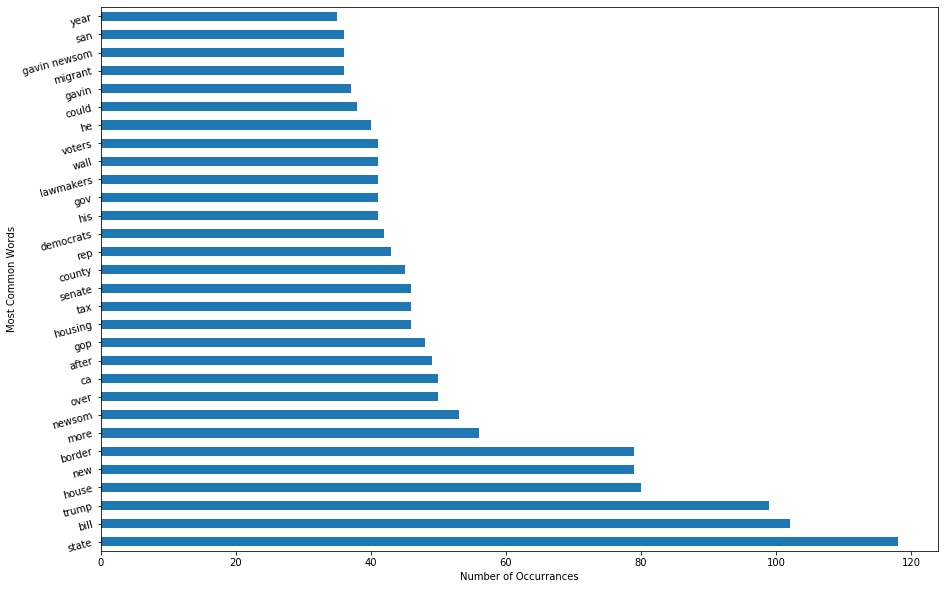

In [7]:
plt.figure(figsize=(15,10))
X_train_df.sum().sort_values(ascending=False).head(30).plot.barh(color='tab:blue')
plt.yticks(rotation=15)
plt.xlabel("Number of Occurrances")
plt.ylabel("Most Common Words")
plt.show()


In [8]:
X_test_df.sum().sort_values(ascending=False)

trump                    38
state                    38
new                      29
border                   27
bill                     27
more                     25
house                    23
after                    22
who                      21
newsom                   21
ca                       18
vote                     18
out                      17
tax                      16
have                     16
could                    16
election                 15
gov                      15
san                      15
big                      14
000                      14
county                   14
governor                 14
2020                     14
over                     14
we                       13
democrats                13
housing                  13
gavin                    13
gavin newsom             13
he                       13
his                      12
against                  12
school                   12
do                       11
crisis              

In [9]:
y_train_df = y_train_df.reset_index()
y_train_df

,index,is_ca
0,208,1
1,1906,0
2,337,1
3,506,1
4,30,1
5,819,1
6,427,1
7,657,1
8,1565,0
9,1149,0


In [10]:
# print(X_train_df.index)
# print(y_train_df.reset_index().index)

corr = pd.concat([X_train_df, y_train_df], axis=1)

In [11]:
corr.corr()[['is_ca']].sort_values('is_ca', ascending=False).head(100)

,is_ca
is_ca,1.000000
newsom,0.196341
gavin,0.166275
ca,0.165732
gavin newsom,0.163955
housing,0.146495
los angeles,0.111912
los,0.111912
angeles,0.111912
prop,0.099973


In [12]:
lr = LogisticRegression()
lr.fit(X_train_df, y_train)
print(lr.score(X_train_df, y_train))
print(lr.score(X_test_df, y_test))
print(f'Intercept: {lr.intercept_}')
print('')
print(f'Coefficient: {lr.coef_}')
print('')
print(f'Exponentiated Coefficient: {np.exp(lr.coef_)}')


0.9736111111111111
0.8208333333333333
Intercept: [0.36593522]

Coefficient: [[-0.73266484  0.65766583 -0.6737202  ... -0.24939142 -0.09697241
  -0.0481543 ]]

Exponentiated Coefficient: [[0.48062649 1.93028146 0.50980846 ... 0.77927489 0.90758104 0.95298673]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
print(f'Logreg predicted values: {lr.predict(X_train_df.head())}')
print(f'Logreg predicted probabilities: {lr.predict_proba(X_train_df.head())}')


Logreg predicted values: [1 0 1 1 1]
Logreg predicted probabilities: [[3.62567723e-04 9.99637432e-01]
 [5.62071023e-01 4.37928977e-01]
 [6.79951895e-02 9.32004811e-01]
 [9.49071264e-02 9.05092874e-01]
 [1.78201276e-01 8.21798724e-01]]


In [14]:
preds = lr.predict(X_test_df)
confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.


array([[195,  50],
       [ 36, 199]])

In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [16]:
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.7959


In [17]:
sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.8468


In [20]:
coef_df = pd.DataFrame({'variables':X_train_df.columns})
print(lr.coef_.shape)
coe = pd.DataFrame({'ß - Beta':np.squeeze(lr.coef_)})
coef_df = pd.concat([coef_df, coe], axis=1)
values = pd.DataFrame(X_train_df, index=list(range(0,2049)), columns=coef_df['variables'])
values['CA_Post'] = y
values.head()

(1, 1500)


variables,000,10,100,100 days,10th,11,12,120,13,14,16,16 year,18,19,1st,20,2016,2018,2019,2020,2020 presidential,21,24,25,30,39,40,48,49,50,50 rep,500,60,70,86th,abbott,able,abortion,abortions,access,accused,across,action,activist,activists,ad,address,administration,admissions,admissions scandal,admits,advances,advances bill,advisory,advocates,affairs,affected,afford,affordability,affordable,affordable housing,after,ag,again,against,against trump,age,agency,agents,aggressive,agrees,ahead,aid,aide,aims,air,alexandria,alexandria ocasio,all,allegations,allies,allow,allowed,allowing,almost,already,am,ama,amendment,america,american,americans,amid,among,amp,an,an eye,analysis,angeles,angeles county,announcement,announces,another,anti,antonio,any,anyone,anyone have,appeal,approval,approval voting,approves,april,area,aren,armed,arrested,arrests,ask,assault,assembly,assemblyman,asylum,attack,attempt,attorney,attorney general,austin,authority,away,baby,back,backed,background,backlash,bad,bail,ballot,ban,bank,banning,bans,battle,bay,bay area,beach,became,because,becerra,become,becomes,been,beer,beer go,before,behind,being,berkeley,bernie,bernie sanders,best,beto,beto rourke,between,bid,biden,big,bigger,bill,bill aims,bill allowing,bill ban,bill banning,bill could,bill make,bill passes,bill would,billion,billion budget,bills,bipartisan,block,blocks,blue,blue wave,board,bonnen,border,border crisis,border patrol,border wall,botched,both,boy,break,bribery,bringing,broken,brown,budget,build,building,built,business,ca,ca 25,ca 48,ca 50,ca gov,ca prop,calif,californians,call,called,calls,calmatters,cameras,camp,camp fire,campa,campa najjar,campaign,campaign funds,camps,campus,candidate,candidates,cannabis,capitol,car,care,carry,cars,case,case against,cases,cash,castro,caucus,cbd,census,center,centers,central,chair,chairman,challenge,challenger,challenges,chance,...,someone,south,southern,southern border,speaker,speaker dennis,special,special election,speech,speed,spending,spent,stand,star,start,starting,starts,state,state david,state government,state law,state rep,state senate,state senator,state state,state university,statement,states,statewide,station,step,stepped,steve,stickland,still,stop,stops,story,strategy,straus,street,strike,strikes,student,students,study,sub,sue,sued,sues,sues over,suing,support,suppression,supreme,supreme court,surge,surplus,surprise,suspect,suspected,swalwell,system,take,takes,taking,talk,targeting,targets,tarrant,tarrant county,tax,tax reform,tax relief,tax returns,taxes,taxpayer,teacher,teachers,team,ted,ted cruz,tells,tenant,tent,term,testimony,texan,texans,texaspolitics,than,thanks,their,them,there,these,things,think,third,third party,those,thousands,threat,threatens,three,through,thursday,time,times,tobacco,today,told,too,top,town,town hall,toxic,track,traffic,trafficking,trail,transparency,tribune,troops,trump,trump administration,trump border,trump emergency,trump he,trump threatens,trump wants,try,trying,turn,twitter,two,tx,uc,unaccompanied,unconstitutional,under,under investigation,unemployment,union,unions,university,until,upholds,upset,urging,us,use,use voting,used,using,ut,utilities,utility,vaccine,vaccine bill,valley,vice,victim,video,visit,vote,voted,voter,voter citizenship,voter fraud,voter purge,voter registration,voter suppression,voters,votes,voting,voting machines,vs,waiting,wall,want,wants,war,warnings,warns,warren,wars,was,washington,watch,water,wave,way,ways,we,we re,wealthy,website,weed,weeks,weigh,well,wells,went,were,west,when,when comes,where,which,while,white,white house,whitley,who,why,wildfire,wildfires,win,wins,withhold,without,woman,women,won,words,work,workers,working,world,worse,worst,worth,would,wrong,xavier,xavier becerra,year,year old,years,yes,yet,you,you need,you think,young,your,your state,zero,CA_Post
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

<Figure size 1080x720 with 0 Axes>

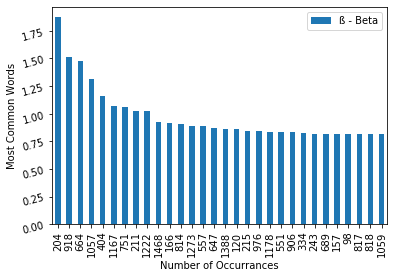

In [43]:
plt.figure(figsize=(15,10))
coef_df.sort_values(by='ß - Beta', ascending=False).head(30).plot.bar(color='tab:blue')
plt.yticks(rotation=15)
plt.xlabel("Number of Occurrances")
plt.ylabel("Most Common Words")
plt.show()


In [21]:
coef_df.sort_values('ß - Beta', ascending=False)

,variables,ß - Beta
204,ca,1.873105
918,newsom,1.509697
664,housing,1.475384
1057,proposition,1.313723
404,do,1.164820
1167,sacramento,1.071410
751,la,1.061357
211,californians,1.028646
1222,sf,1.024795
1468,wildfires,0.924792


In [ ]:
cali_mask = np.array(Image.open("./download.png"))
cali_mask

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
transformed_cali_mask = np.ndarray((cali_mask.shape[0],cali_mask.shape[1]), np.int32)

for i in range(len(cali_mask)):
    transformed_cali_mask[i] = list(map(transform_format, cali_mask[i]))


In [ ]:
im_small = zoom(transformed_cali_mask, (2.25))

In [ ]:
df_reddit.loc[(df_reddit['ca'] == 1)]['title']
text = " ".join(post for post in (df_reddit.loc[(df_reddit['ca'] == 1)]['title'])) # This is getting me just the words for posts on the CA Subreddit
print ("There are {} words in all posts.".format(len(text)))

In [ ]:
wordcloud = WordCloud(stopwords=stop_words, max_font_size=30, max_words=500, background_color="white", mask=im_small, contour_color='grey', contour_width=0.5).generate(text)
plt.figure(figsize= [8,23])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [44]:
results = pd.DataFrame(lr.predict(X_test_df), columns=['predicted'])

# Create column for observed values.
y_test = y_test.reset_index()
y_test.head()
results['actual'] = y_test['is_ca']

In [45]:
results.head()

,predicted,actual
0,0,1
1,1,1
2,1,1
3,0,0
4,0,0


In [46]:
row_ids = results[results['predicted'] != results['actual']].index

In [47]:
row_ids

Int64Index([0, 18, 25, 28, 32, 35, 38, 45, 47, 49, 50, 51, 54, 71, 73, 77, 79, 82, 85, 91, 94, 100, 104, 107, 111, 116, 125, 126, 129, 136, 139, 148, 167, 172, 176, 178, 181, 199, 217, 226, 229, 232, 237, 238, 242, 244, 250, 252, 256, 258, 259, 260, 263, 270, 272, 276, 285, 292, 293, 297, 302, 318, 320, 323, 343, 344, 356, 359, 367, 374, 375, 386, 390, 405, 408, 412, 420, 421, 422, 446, 454, 462, 468, 472, 473, 477], dtype='int64')

## Analysis of Texas subreddit words

In [ ]:
tx_mask = np.array(Image.open("./Texas-shape1.jpg"))

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_tx_mask = np.ndarray((tx_mask.shape[0],tx_mask.shape[1]), np.int32)

for i in range(len(tx_mask)):
    transformed_tx_mask[i] = list(map(transform_format, tx_mask[i]))
